# $$\textbf{Application on BBQ dataset} $$

Description of dataset goes here. 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
sys.path.insert(0, 'utils/')
from factorizer import *
import em
import palettable
from scipy.interpolate import griddata
from palettable.cartocolors.qualitative import Prism_8
import matplotlib as mpl
import pickle
from mpl_toolkits.mplot3d import Axes3D

import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram, linkage

def cosine_abs(x,y):
    return 1.0 + 1e-5 - np.abs(np.dot(x,y))/np.sqrt(np.dot(x,x)*np.dot(y,y) + 1e-10)


%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
fig_path = "./figures/BBQ/"

In [3]:
def get_pheno_from_file(filename,N): 
    Y = np.genfromtxt(filename,skip_header = 1, skip_footer = 1, usecols = (1))
    Y = Y[:N]
    return Y

def gather_l21_F_XY(file_g, file_f, file_c, file_m, path_to_pheno, envs, seed):
    X = np.load(file_g)
    loci = np.load(file_c)
    map_ = np.load(file_m)
    causal_loci = np.where(map_ == True)[0][loci]
    np.random.seed(seed)
    
    # restrict to causal loci
    X = X[:, causal_loci] ##The causal loci should have their true coordinates

    # load phenotypes (fitness) in envs
    Y = np.zeros((X.shape[0], len(envs)))
    for _,env in enumerate(envs):
        Y[:,_] = get_pheno_from_file(f"{path_to_pheno}pheno_data_{env}.txt", X.shape[0])

    print("No. of genotypes: %d  " %Y.shape[0], "No. of loci: %d  " %X.shape[1], "No. of envs: %d  " %Y.shape[1])

    # filter out genotypes with NaN fitness
    filter_out_nan = Y==Y
    filter_out_nan = np.sum(filter_out_nan, axis = -1 ) == len(envs)

    Y = Y[filter_out_nan, :]
    X = X[filter_out_nan, :]

    filt = np.random.choice(len(X),size = int(0.9*len(X)), replace = False)
    split = np.zeros(len(X),dtype=bool)
    split[filt] = 1
    Xtrain = X[split]
    Ytrain = Y[split]
    Xval = X[~split]
    Yval = Y[~split]
    
    vfilt = np.random.choice(len(Xval),size = int(0.5*len(Xval)), replace = False)
    vsplit = np.zeros(len(Xval),dtype=bool)
    vsplit[vfilt] = 1
    Xtest = Xval[vsplit]
    Ytest = Yval[vsplit]
    Xval = Xval[~vsplit]
    Yval = Yval[~vsplit]

    
    F = np.load(file_f).T
    return F, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, causal_loci, envs

def filter_envs(remove_envs, F, Ytrain, Yval, envs):
    if remove_envs is not None:
        filt_envs = [e not in remove_envs for e in envs]
    else:
        filt_envs = np.ones(len(envs), dtype=bool)
    return F[filt_envs], Ytrain[:,filt_envs],  Yval[:,filt_envs], envs[filt_envs]
    

In [4]:
envs=["4NQO","23C","25C","27C","30C","33C","35C","37C","cu","eth","gu","li","mann","mol","raff","sds","suloc","ynb"]
file_g = "../../BBQ_data/geno_data_bool_96000.npy"
file_m = "./results/BBQ/loci_kept_cc_0.99.npy"
seed = 0
path_to_pheno = "../../BBQ_data/"

mt = "1.0001"
cc_list = ["0.96","0.93","0.9"]
mc_str = "_".join(cc_list)
print(mt, mc_str)
file_f = f"./results/BBQ/elim_coeffs_mt_{mt}_mc_{mc_str}_for_glm_cc_0.99_seed_0.npy"
file_c = f"./results/BBQ/elim_positions_mt_{mt}_mc_{mc_str}_for_glm_cc_0.99_seed_0.npy"
F, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, causal_loci, envs = gather_l21_F_XY(file_g, file_f, file_c, file_m, path_to_pheno, envs, 0)

1.0001 0.96_0.93_0.9
No. of genotypes: 96000   No. of loci: 267   No. of envs: 18  


## 3D plot with additive effects and identified causal loci 

In [5]:
X = np.load(file_g)
# load phenotypes (fitness) in envs
Y = np.zeros((X.shape[0], len(envs)))
for _,env in enumerate(envs):
    Y[:,_] = get_pheno_from_file(f"{path_to_pheno}pheno_data_{env}.txt", X.shape[0])
    

In [6]:
E = Y.shape[1]
S = X.shape[1]
L = len(causal_loci)
Fraw = np.zeros((E,S))

print(E,S)
N = 5000

for i in range(S):
    filt = X[:N,i] == True
    Fraw[:,i] = 0.5*(np.nanmean(Y[:N][filt],axis=0) - np.nanmean(Y[:N][~filt],axis=0))

18 41594


29


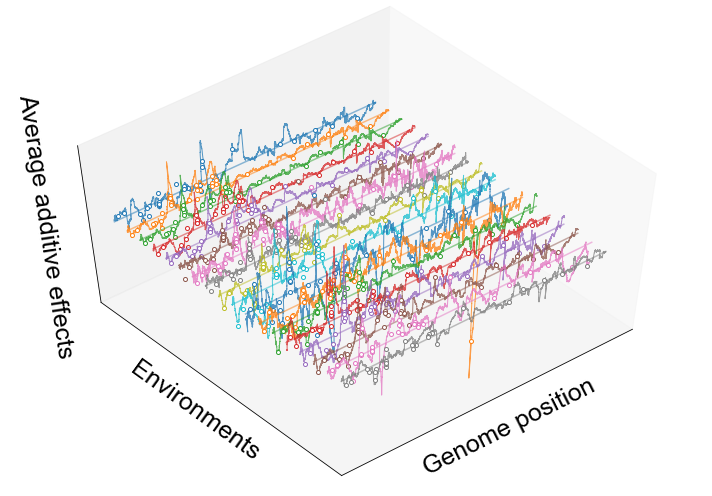

In [7]:
plt.close("all")
fig = plt.figure(figsize = (10,7))

ax = fig.add_subplot(111, projection='3d')

filtL = np.mean(np.abs(F),axis=0) > 0.0034
print(sum(filtL))

for e in range(E):
    ax.plot(np.arange(S),np.ones(S)*e,Fraw[e,:], 'C%d-'%(e%10), alpha = 0.75,lw = 1)
    ax.plot(np.arange(S),np.ones(S)*e,np.zeros(S),'C%d-'%(e%10), alpha = 0.5)
    
    
    
    
    ax.plot(causal_loci[filtL], np.ones(len(causal_loci[filtL]))*e, F[e,filtL]/2,'C%do'%(e%10), ms = 4, mfc = 'w', mew = 1)
    
#     for l in range(len(causal_loci)):
#         pos = causal_loci[l]
#         ax.plot([pos,pos], [e,e], [0,F[e,l]/2],'C%d-'%(e%10), lw = 0.8)



ax.tick_params(labelsize = 14)
ax.set_zlim(-0.025,0.025)
ax.set_ylim(0,18)
ax.grid('off')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_yticklabels(envs,fontsize = 12)
ax.set_zticks([])
ax.set_zlabel("Average additive effects", fontsize = 25)
ax.set_xlabel("Genome position", fontsize = 25)
ax.set_ylabel("Environments", fontsize = 25)
ax.view_init(elev = 55, azim = 50)
fig.tight_layout()
#ax.set_zticks([])
#ax.axis('off')
fig.savefig(fig_path + "BBQ_Fraw_3d.pdf")
plt.show()

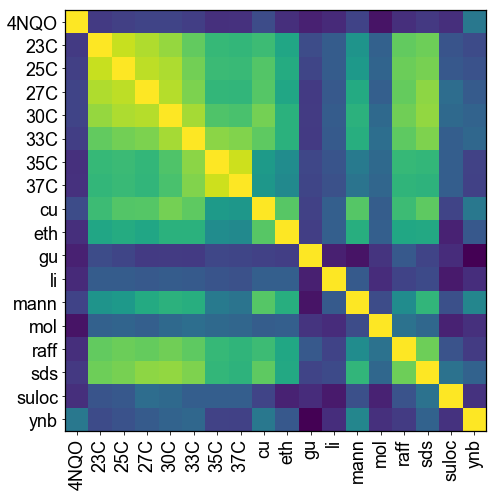

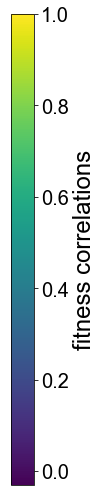

In [30]:
#covariance across environments

filt = np.ones(Y.shape[0],dtype = bool)
for i in range(len(filt)):
    if np.sum(Y[i]) != np.sum(Y[i]):
        filt[i] = False
cov = np.corrcoef(Y[filt].T)


plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (7,7))
im = axis.imshow(cov)
#cb= fig.colorbar(mappable = im, ax = axis)
#cb.ax.tick_params(labelsize = 16)
axis.set_yticks(np.arange(E))
axis.set_yticklabels(envs)
axis.set_xticks(np.arange(E))
axis.set_xticklabels(envs, rotation=90)
axis.tick_params(labelsize= 18)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)
fig.tight_layout()
fig.savefig(fig_path + "BBQ_pheno_corrs.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (7,7))
#im = axis.imshow(cov)
cb= fig.colorbar(mappable = im)
cb.set_label("fitness correlations", fontsize = 24)
cb.ax.tick_params(labelsize = 20)
axis.remove()

fig.tight_layout()
fig.savefig(fig_path + "BBQ_pheno_corrs_cb.pdf")
plt.show()




## Load pickled data and set parameters used for decompositions 

In [13]:
mode = "BBQ_1128"
fcts= pickle.load(open(f"pickled_factorizers/{mode}","rb"))

lamb1_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),25))
lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),25))
lamb1_fixed = [1e-4]
lamb2_fixed = [1e-3]
svd_k = 8
mws = 0

## Plot rotation tests 

8 18 1128


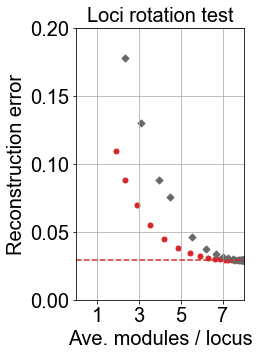

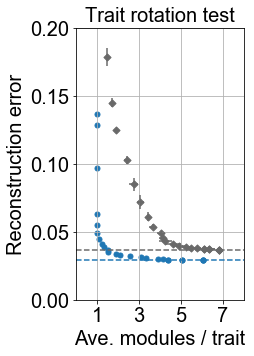

In [15]:
yrange = (0,.2)
xrange = (0,8)
figsize = (3,5)

name = mode
fct = fcts[(name , None,None)]
K = fct.computed_params(printout = False)[0][1]
print(K, fct.FF.shape[0], fct.FF.shape[1])

fct_rots = [fcts[(name, None, i)] for i in [3,4,5]] 
rotate = "loci"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_fixed, lamb2_range, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,3,5,7], oc='tab:red', rotc='dimgrey', labels= True, legend = False)

fct_rots = [fcts[(name, i, None)] for i in [0,1,2]] 
rotate = "env"
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_range, lamb2_fixed, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.pdf", figsize = figsize, xticks = [1,3,5,7], oc='tab:blue', rotc='dimgrey', labels= True, legend = False)

## Solution space 

('reg', 8, (0.0022, 0.6013), (0, 0)) 3.144308943089431 1.6470588235294117 8 0.07920334536613673


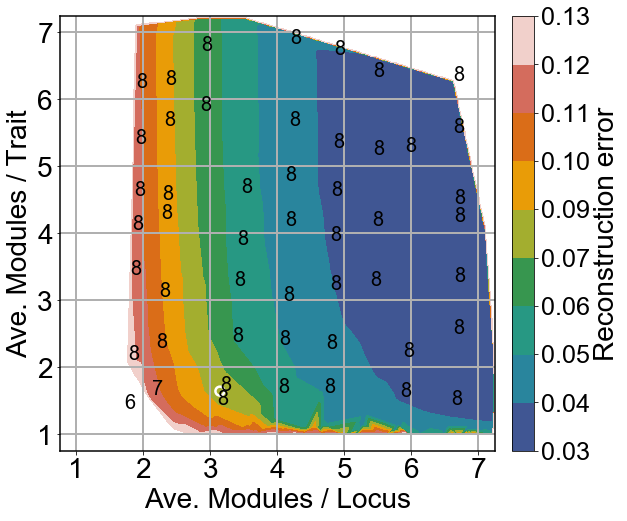

In [33]:
ve = .25
minx = 1-ve
maxx = 7+ve
miny = 1-ve
maxy = 7+ve
vmax = 0.13
vmin = 0.03

K = 8

kpts = []
for i in np.linspace(1.5,6.5,7):
    for j in np.linspace(1.5,6.5,7):
        kpts.append((i,j))
        
cps = [(3.2,1.6)]
kpts += cps

plot_solution_space(fct, K, lamb1_range, lamb2_range,  minx, maxx, miny, maxy, vmax, vmin, \
                    fs = 28,scatter=False, scatter_restricted=True, restrict_in_range = True,\
                    k_labeled_points = kpts, circled_points = cps,  save_name = fig_path + "sols_" + mode + ".pdf")

## W and M


W: plot



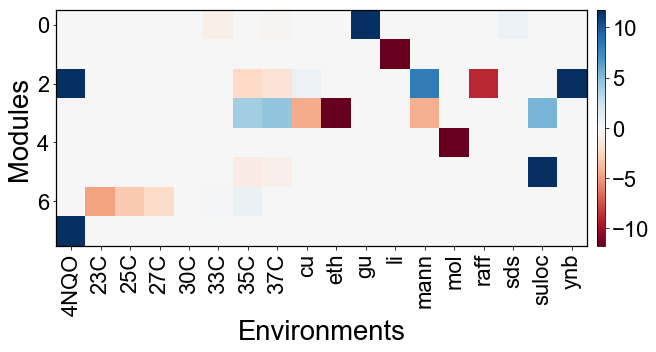

In [197]:
F = fct.FF
p = fct.find_key(3.2,1.6)
plot_Ws(fct, p, pp = 97, labelsize = 22,save_name = fig_path + "W_" + mode + ".pdf")
# filtl =  np.mean(np.abs(F),axis=0) > 0.0034
# plot_Ms(fct, p, pp = 97, restricted = filtl, two_line= False, labelsize = 24, max_cols = 120, save_name = fig_path + "M_" + mode + ".pdf")
# display_modularity(fct, p, save_name =  fig_path + "modhist_" + mode + ".pdf")

# print(1.6*18 + 3.2*1128, 1128*18)

In [192]:
p = fct.find_key(3.2,1.6)
M = fct.M_preds[p]

filt = np.sum(M**2,axis=0) > 0.01
print(np.sum(filt))

thresh = 0.05
Z = linkage(M.T[filt], metric = cosine_abs, method = 'complete', optimal_ordering=True)
Z = linkage(np.abs(M.T[filt]) > thresh , metric = 'jaccard', method = 'complete', optimal_ordering=True)

cluster_labels = np.zeros(M.shape[1])
cluster_labels[filt] = hac.fcluster(Z,0.1, criterion='distance')
print(np.max(cluster_labels))

89
48.0


In [193]:
sorted_ = np.argsort(-np.sum(np.abs(M),axis=0))
cluster_labels_s = cluster_labels[sorted_]

[np.sum(cluster_labels == index) for index in range(1,int(np.max(cluster_labels)))]

[1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 6,
 1,
 1,
 6,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 9,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 5,
 4,
 4,
 1]

[33213 33216 37698 33215]


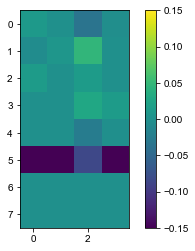

[[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]]

[[ 0.011 -0.004  0.015 -0.    -0.    -0.464  0.     0.   ]
 [-0.     0.008  0.    -0.     0.    -0.263 -0.     0.   ]
 [-0.035  0.047  0.014  0.029 -0.024 -0.085  0.     0.   ]
 [-0.002 -0.     0.     0.015 -0.    -0.188 -0.    -0.   ]]


In [196]:
index = 45
filt = cluster_labels_s == index

names = fct.loci_names[sorted_][filt]

indices = [np.where(fct.loci_names == names[i])[0][0] for i in range(len(names))]
print(names)
plt.close("all")
plt.imshow(M[:,indices], vmin = -0.15,vmax=  0.15)
#plt.imshow(M[:,indices]/np.sqrt(np.sum(M[:,indices]**2,axis=0)), vmin = -0.5,vmax=  0.5)
plt.colorbar()
plt.show()

np.set_printoptions(suppress=True, precision = 3)
print(1*(np.abs(M[:,indices]) > thresh).T)
print("")
print(M[:,indices].T)

In [205]:
Xval.shape[0]/(Xtrain.shape[0] + Xval.shape[0])

0.052641656195775745